Тетрадка для предобработки данных.

# Import

In [46]:
import os
from dotenv import load_dotenv

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer, StandardScaler, LabelEncoder

import torch
from torch.utils.data import Dataset


load_dotenv()

True

# Config

In [2]:
INPUT_DATA_PATH = os.getenv("INPUT_DATA_PATH")
OUTPUT_DATA_PATH = os.getenv("OUTPUT_DATA_PATH")

# Classes and functions

Реализация класса для работы с данными ([документация](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)).

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, dataset_path: str, label_name: str, transform: Pipeline | None = None, target_transform: Pipeline | None = None):
        dataset = pd.read_csv(dataset_path)
        self.X, self.y = dataset.drop(label_name, axis=1), dataset[label_name]
        self.transform = transform
        self.target_transform = target_transform

        if self.transform:
            self.X = self.transform.fit_transform(self.X)
        
        if self.target_transform:
            self.y = self.target_transform.fit_transform(self.y)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X.iloc[idx], self.y.iloc[idx]

# EDA

In [7]:
user_ds_path = os.path.join(INPUT_DATA_PATH, "Предсказание количества просмотров рекламы/users.tsv")
history_ds_path = os.path.join(INPUT_DATA_PATH, "Предсказание количества просмотров рекламы/history.tsv")
validate_ds_path = os.path.join(INPUT_DATA_PATH, "Предсказание количества просмотров рекламы/validate.tsv")

validate_answers_ds_path = os.path.join(INPUT_DATA_PATH, "Предсказание количества просмотров рекламы/validate_answers.tsv")

In [99]:
user_ds = pd.read_csv(user_ds_path, sep="\t")
history_ds = pd.read_csv(history_ds_path, sep="\t")
validate_ds = pd.read_csv(validate_ds_path, sep="\t")

validate_answers_ds = pd.read_csv(validate_answers_ds_path, sep="\t")

## Missed values

In [35]:
user_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27769 entries, 0 to 27768
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   user_id  27769 non-null  int64
 1   sex      27769 non-null  int64
 2   age      27769 non-null  int64
 3   city_id  27769 non-null  int64
dtypes: int64(4)
memory usage: 867.9 KB


In [36]:
history_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1147857 entries, 0 to 1147856
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   hour       1147857 non-null  int64  
 1   cpm        1147857 non-null  float64
 2   publisher  1147857 non-null  int64  
 3   user_id    1147857 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 35.0 MB


In [37]:
validate_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1008 entries, 0 to 1007
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   cpm            1008 non-null   float64
 1   hour_start     1008 non-null   int64  
 2   hour_end       1008 non-null   int64  
 3   publishers     1008 non-null   object 
 4   audience_size  1008 non-null   int64  
 5   user_ids       1008 non-null   object 
dtypes: float64(1), int64(3), object(2)
memory usage: 47.4+ KB


In [38]:
validate_answers_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1008 entries, 0 to 1007
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   at_least_one    1008 non-null   float64
 1   at_least_two    1008 non-null   float64
 2   at_least_three  1008 non-null   float64
dtypes: float64(3)
memory usage: 23.8 KB


___
В данных нет None значений, но нужно исследовать значения признаков.

## Values analyse

### users.tsv

In [5]:
user_ds.head()

,user_id,sex,age,city_id
0,0,2,19,0
1,1,1,0,1
2,2,2,24,2
3,3,1,20,3
4,4,2,29,4


In [10]:
len(user_ds) == len(user_ds["user_id"].unique())

True

In [12]:
np.unique(user_ds["sex"], return_counts=True)

(array([0, 1, 2]), array([   30, 14515, 13224]))

In [38]:
len(user_ds[user_ds["age"] == 0])

2180

In [40]:
len(user_ds[user_ds["city_id"] == 0])

8479

Text(0, 0.5, 'count')

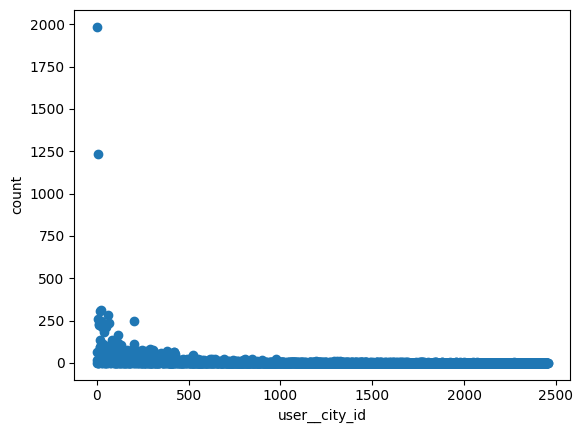

In [109]:
uniq_users_city_id = np.unique(user_ds[user_ds["city_id"] != 0]["city_id"], return_counts=True)

plt.scatter(uniq_users_city_id[0], uniq_users_city_id[1])
plt.xlabel("user__city_id")
plt.ylabel("count")

### history.tsv

In [41]:
history_ds.head()

,hour,cpm,publisher,user_id
0,10,30.00,1,15661
1,8,41.26,1,8444
2,7,360.00,1,15821
3,18,370.00,1,21530
4,8,195.00,2,22148


In [44]:
round(history_ds[["hour", "cpm"]].describe(), 2)

,hour,cpm
count,1147857.00,1147857.00
mean,760.30,186.40
std,430.62,455.73
min,3.00,30.00
25%,392.00,55.00
50%,762.00,110.00
75%,1138.00,210.00
max,1490.00,209053.98


Text(0.5, 0, 'history__hour')

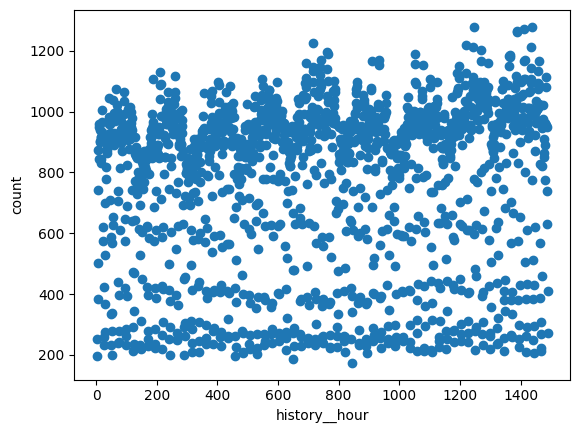

In [ ]:
plt.scatter(history_ds["hour"].value_counts().index, history_ds["hour"].value_counts().values)
plt.xlabel("history__hour")
plt.ylabel("count")

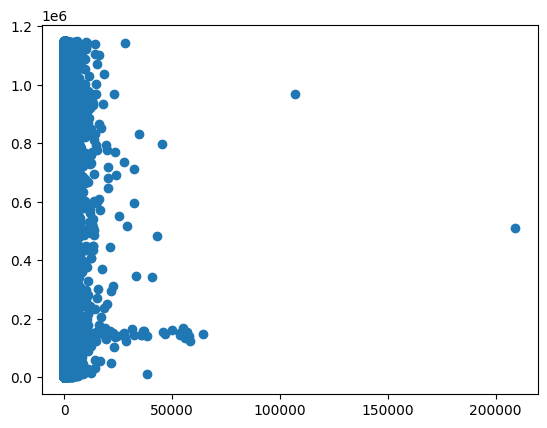

In [47]:
plt.scatter(history_ds["cpm"], history_ds.index)

Text(0, 0.5, 'count')

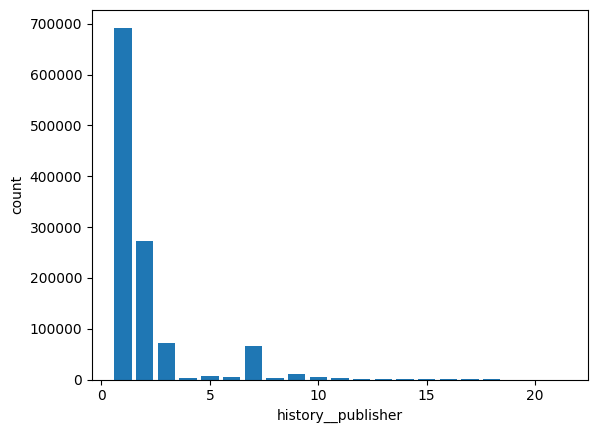

In [75]:
uniq_history_publisher = np.unique(history_ds["publisher"], return_counts=True)

fig, ax = plt.subplots()
ax.bar(uniq_history_publisher[0], uniq_history_publisher[1])
ax.set_xlabel("history__publisher")
ax.set_ylabel("count")

Text(0, 0.5, 'count')

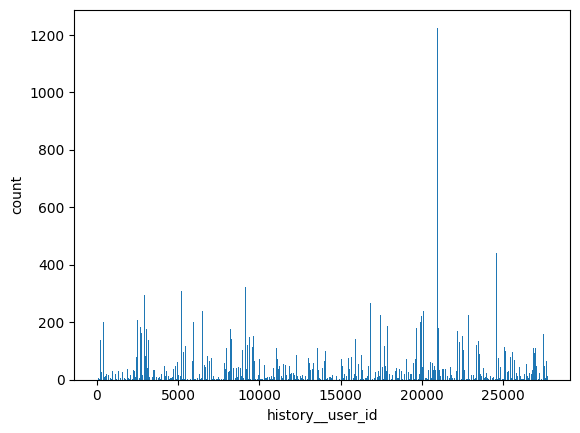

In [80]:
uniq_history_user_id = np.unique(history_ds["user_id"], return_counts=True)

fig, ax = plt.subplots()
ax.bar(uniq_history_user_id[0], uniq_history_user_id[1])
ax.set_xlabel("history__user_id")
ax.set_ylabel("count")

### validate.tsv

In [100]:
validate_ds["len_publishers"] = validate_ds["publishers"].apply(lambda x: len([int(v) for v in x.split(",")]))
validate_ds.head()

,cpm,hour_start,hour_end,publishers,audience_size,user_ids,len_publishers
0,220.0,1058,1153,"7,17",1906,"12,44,46,50,58,71,93,122,134,143,176,184,187,1...",2
1,312.0,1295,1301,"3,18",1380,"29,81,98,102,165,167,195,205,218,231,242,263,3...",2
2,70.0,1229,1249,"1,2,3,9,15,21",888,"12,23,25,29,45,85,92,124,156,190,272,334,456,5...",6
3,240.0,1295,1377,"1,14",440,"44,122,187,209,242,255,312,345,382,465,513,524...",2
4,262.0,752,990,"1,3,7,8",1476,"15,24,30,43,50,53,96,105,159,168,181,190,196,2...",4


In [83]:
round(validate_ds[["cpm", "audience_size"]].describe(), 2)

,cpm,audience_size
count,1008.00,1008.00
mean,162.43,1090.09
std,112.19,613.56
min,30.00,300.00
25%,79.00,575.00
50%,130.00,960.00
75%,220.00,1464.00
max,475.00,2500.00


Text(0, 0.5, 'count')

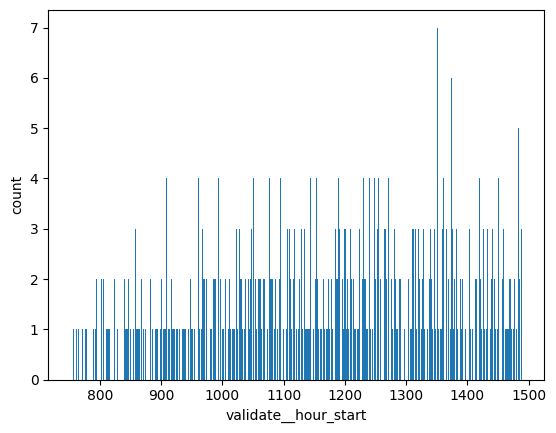

In [86]:
uniq_validate_hour_start = np.unique(validate_ds["hour_end"], return_counts=True)

fig, ax = plt.subplots()
ax.bar(uniq_validate_hour_start[0], uniq_validate_hour_start[1])
ax.set_xlabel("validate__hour_start")
ax.set_ylabel("count")

Text(0, 0.5, 'count')

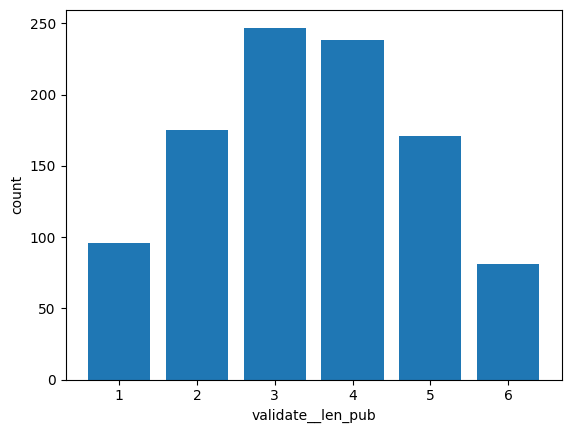

In [98]:
uniq_validate_len_pub = np.unique(validate_ds["len_publishers"], return_counts=True)

fig, ax = plt.subplots()
ax.bar(uniq_validate_len_pub[0], uniq_validate_len_pub[1])
ax.set_xlabel("validate__len_pub")
ax.set_ylabel("count")

### conclusion

___
**users.tsv:**
- все пользователи уникальные,
- 30 пользователей без пола, примерно 50/50,
- 2180 пропущено возрастов, есть люди страше 90 лет,
- 84790 пропущено городов, город с id=3 концентрирует в себе пользователей.

**history.tsv:**
- два выброса по cpm,
- есть периодичность по времени,
- все просмотры сконцентрированы на 4 площадках,
- два пользователя смотрят очень много объявлений (мб выбросы и стоит обрезать).

**validate.tsv:**
- максимум используется 6 площадок, в основном 3-4.

## Filter values

Изменение возраста.

Мб есть люди, которые возраст поставили наугад.

Разобьем людей на возрастные группы и посмотрим на их статистики. Мб группы будут пересекаться.

In [112]:
none_age_users = user_ds[user_ds["age"] == 0]
full_age_users = user_ds[user_ds["age"] != 0]

In [124]:
# Добавляем столбец с временными метками
# (по ним можно узнать: сколько раз пользователь видел объявления и в какое время)
none_age_users["hours"] = none_age_users["user_id"].apply(lambda x: history_ds[history_ds["user_id"] == x]["hour"].unique())
full_age_users["hours"] = full_age_users["user_id"].apply(lambda x: history_ds[history_ds["user_id"] == x]["hour"].unique())

/tmp/ipykernel_1721734/3198654064.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  none_age_users["hours"] = none_age_users["user_id"].apply(lambda x: history_ds[history_ds["user_id"] == x]["hour"].unique())
/tmp/ipykernel_1721734/3198654064.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_age_users["hours"] = full_age_users["user_id"].apply(lambda x: history_ds[history_ds["user_id"] == x]["hour"].unique())


In [130]:
# Добавляем столбец с площадками
# (можно посмотреть на каких площадках сидит пользователь)
none_age_users["publishers"] = none_age_users["user_id"].apply(lambda x: history_ds[history_ds["user_id"] == x]["publisher"].unique())
full_age_users["publishers"] = full_age_users["user_id"].apply(lambda x: history_ds[history_ds["user_id"] == x]["publisher"].unique())

/tmp/ipykernel_1721734/636257355.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  none_age_users["publishers"] = none_age_users["user_id"].apply(lambda x: history_ds[history_ds["user_id"] == x]["publisher"].unique())
/tmp/ipykernel_1721734/636257355.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_age_users["publishers"] = full_age_users["user_id"].apply(lambda x: history_ds[history_ds["user_id"] == x]["publisher"].unique())


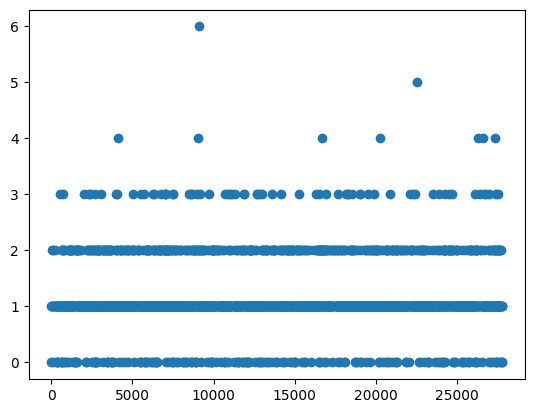

In [137]:
plt.scatter(none_age_users["user_id"], none_age_users["publishers"].apply(lambda x: len(x)))

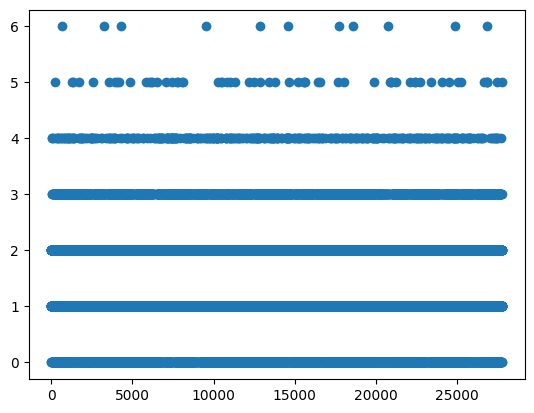

In [133]:
plt.scatter(full_age_users["user_id"], full_age_users["publishers"].apply(lambda x: len(x)))

## Form dataset

# Preprocess

In [ ]:
# Define the data path and taget
dataset_path = os.path.join(INPUT_DATA_PATH, "name_of_file.csv")
label_name = "label_name"
# Define the transformers
feature_transform = Pipeline([
    ("normalizer", Normalizer()),
    ("scaler", StandardScaler())
])
target_transform = Pipeline([
    ("label_encoder", LabelEncoder())
])
# Create the dataset
train_dataset = CustomImageDataset(
    dataset_path=dataset_path,
    label_name=label_name,
    transform=feature_transform,
    target_transform=target_transform
)